In [23]:
import pandas as pd
import os
import random

In [24]:
from torchvision.models import resnet50

In [25]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from skimage.transform import resize
import imageio.v3 as iio
import torch
import random
import torch.nn as nn
from pathlib import Path
import numpy as np

# Dataset Path

In [26]:
train_path="/kaggle/input/cosmys-face-datast/Comys_Hackathon5/Task_B/train"
val_path="/kaggle/input/cosmys-face-datast/Comys_Hackathon5/Task_B/val"

# Pair Csv

In [27]:
sample_a_class=5
sample_o_class=6

In [28]:
def all_pair(l1, l2):
    return [(i, j) for i in l1 for j in l2]


def all_files(class_paths):
    imgs = []
    for cls in class_paths:
        all_imgs = get_all_imgs(cls)
        if all_imgs:  
            imgs.append(random.choice(all_imgs))
    return imgs


def get_all_imgs(cls_path):
    imgs = [str(p) for p in cls_path.glob("*") if p.is_file()]
    distortion_dir = cls_path / "distortion"
    if distortion_dir.exists():
        imgs += [str(p) for p in distortion_dir.glob("*") if p.is_file()]
    return imgs

In [29]:
import random
from pathlib import Path

# Main pairing logic
data = []
path = Path(train_path)

for cls in path.iterdir():
    if not cls.is_dir():
        continue

    # Get all images from current class including distortion
    class_imgs = get_all_imgs(cls)
    if len(class_imgs) < max(sample_a_class, sample_o_class):
        continue  # Skip classes with insufficient images

    # +ve pairs
    img1_t = random.sample(class_imgs, sample_a_class)
    img2_t = random.sample(class_imgs, sample_o_class)
    total_p_pair = all_pair(img1_t, img2_t)

    # -ve pairs
    other_classes = [c for c in path.iterdir() if c.name != cls.name and c.is_dir()]
    img1_t = random.sample(class_imgs, sample_a_class)
    img2_t = all_files(random.sample(other_classes, sample_o_class))
    total_n_pair = all_pair(img1_t, img2_t)

    # Store pairs
    for i1, i2 in total_p_pair:
        data.append([i1, i2, 1])
    for i1, i2 in total_n_pair:
        data.append([i1, i2, 0])
df_train=pd.DataFrame(data,columns=["img1", "img2","target"])

In [30]:
df_train.shape

(52620, 3)

In [31]:
import random
from pathlib import Path

# Main pairing logic
data = []
path = Path(val_path)

for cls in path.iterdir():
    if not cls.is_dir():
        continue

    # Get all images from current class including distortion
    class_imgs = get_all_imgs(cls)
    if len(class_imgs) < max(sample_a_class, sample_o_class):
        continue  # Skip classes with insufficient images

    # +ve pairs
    img1_t = random.sample(class_imgs, sample_a_class)
    img2_t = random.sample(class_imgs, sample_o_class)
    total_p_pair = all_pair(img1_t, img2_t)

    # -ve pairs
    other_classes = [c for c in path.iterdir() if c.name != cls.name and c.is_dir()]
    img1_t = random.sample(class_imgs, sample_a_class)
    img2_t = all_files(random.sample(other_classes, sample_o_class))
    total_n_pair = all_pair(img1_t, img2_t)

    # Store pairs
    for i1, i2 in total_p_pair:
        data.append([i1, i2, 1])
    for i1, i2 in total_n_pair:
        data.append([i1, i2, 0])
df_val=pd.DataFrame(data,columns=["img1", "img2","target"])

# Dataset Declaration

In [32]:
df_train.shape , df_val.shape

((52620, 3), (15000, 3))

In [33]:
# pairpicker

from torch.utils.data import Dataset
from pathlib import Path
import imageio.v3 as iio
from skimage.transform import resize
import numpy as np
import torch

class PairPicker(Dataset):
    def __init__(self, df, size=(224, 224)):
        self.df = df.sample(frac=1).reset_index(drop=True)  
        self.size = size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img1_path = Path(row[0])  
        img2_path = Path(row[1])  
        label = torch.tensor(row[2], dtype=torch.float32)  

        
        img1 = iio.imread(img1_path)
        img2 = iio.imread(img2_path)

        
        img1 = self._normalize_and_resize(img1)
        img2 = self._normalize_and_resize(img2)

        return img1, img2, label

    def _normalize_and_resize(self, img):
     
        if np.issubdtype(img.dtype, np.integer):
            info = np.iinfo(img.dtype)
        else:
            info = np.finfo(img.dtype)

        img = (img - info.min) / (info.max - info.min)

        
        img = resize(img, (*self.size, 3), anti_aliasing=True)
        img = torch.from_numpy(img).float().permute(2, 0, 1)

        return img


In [45]:
pairpicker=PairPicker(df_train)
train_loader = DataLoader(pairpicker, batch_size=10, shuffle=True)

# Image Pair Samples

/tmp/ipykernel_35/542835628.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img1_path = Path(row[0])
/tmp/ipykernel_35/542835628.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img2_path = Path(row[1])
/tmp/ipykernel_35/542835628.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(row[2], dtype=torch.float32)


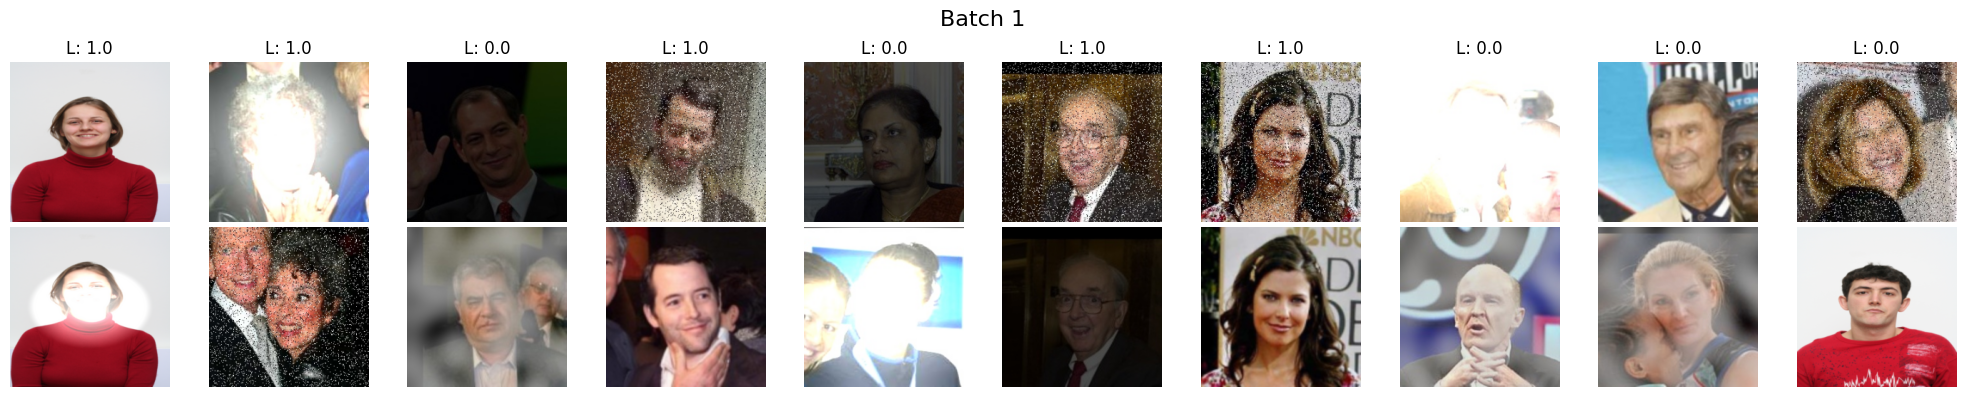

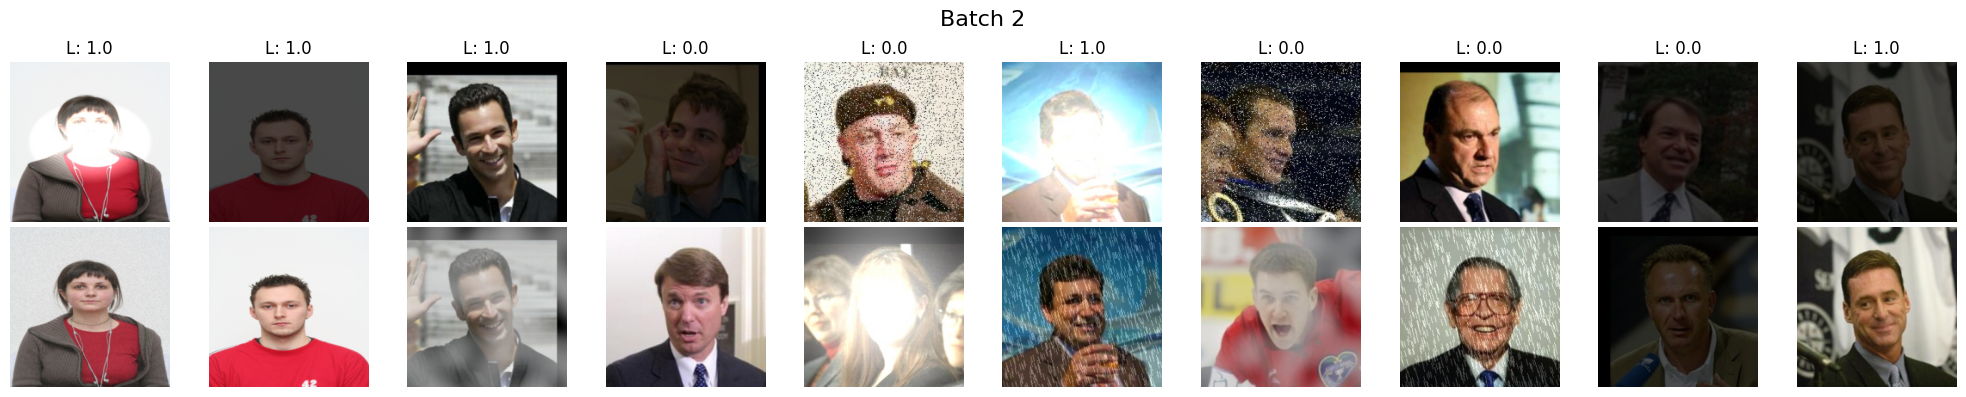

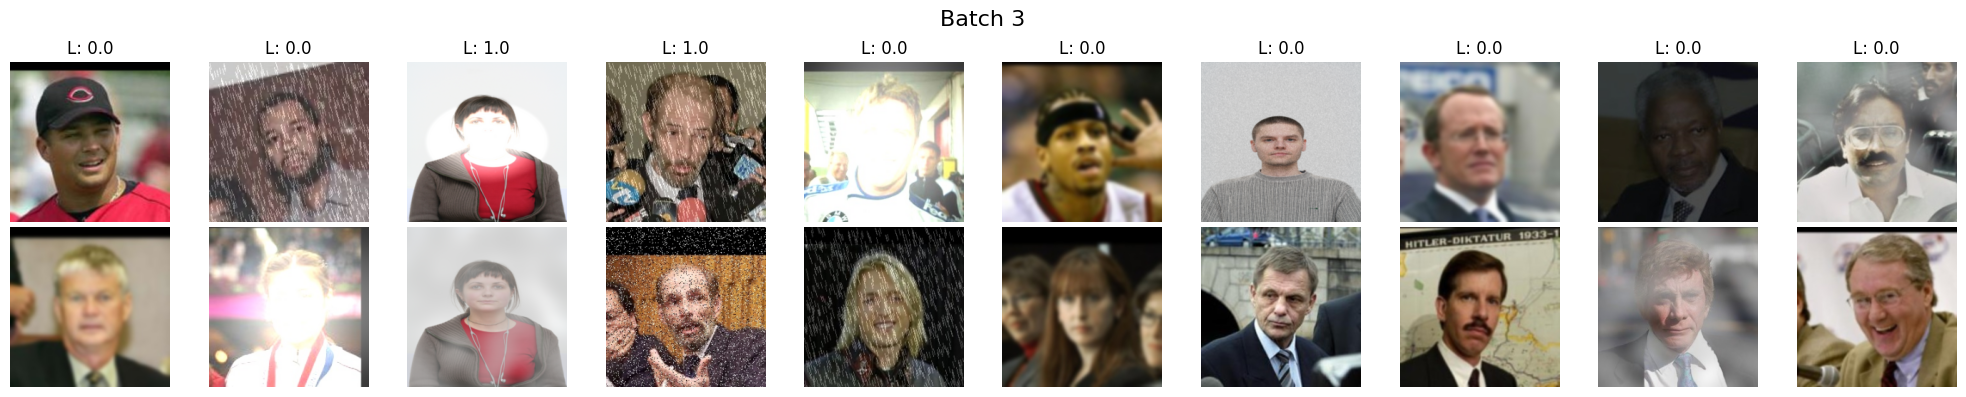

In [35]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

dataloader = DataLoader(pairpicker, batch_size=10, shuffle=True)
batch_count = 0

for img1, img2, label in dataloader:
    
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        img1_np = img1[i].permute(1, 2, 0).numpy()
        img2_np = img2[i].permute(1, 2, 0).numpy()

        axes[0, i].imshow(img1_np)
        axes[0, i].set_title(f"L: {label[i].item()}")
        axes[0, i].axis('off')

        axes[1, i].imshow(img2_np)
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.suptitle(f"Batch {batch_count + 1}", fontsize=16)
    plt.subplots_adjust(top=0.85)
    plt.show()

    batch_count += 1
    if batch_count == 3:
        break


# Model Definition

In [36]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

class Mymodel(nn.Module):
    
    def __init__(self):
        super(Mymodel, self).__init__()
        
        self.f1 = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.f1.fc = nn.Identity()  
        
        self.f2 = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.f2.fc = nn.Identity()
        
        self.classification = nn.Sequential(
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )
        
        self.fc1 = None
        self.fc2 = None
        

    def forward(self, x1, x2):
        
        fv1 = self.f1(x1)
        fv2 = self.f2(x2)
        
        self.fc1 = fv1
        self.fc2 = fv2
        
        dist = torch.abs(fv1 - fv2)
        
        out = self.classification(dist)
        
        return out
        

    def feats(self):
        return (self.fc1, self.fc2)


# Model Training Function Definition

In [37]:
import torch
from torch.utils.data import DataLoader
from torch import optim
from sklearn.metrics import classification_report
import numpy as np

def model_train(model, epoch, pairpicker, device='cuda'):
    
    model.to(device)
    model.train()

    criterion = torch.nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    dataloader = DataLoader(pairpicker, batch_size=10, shuffle=True)

    best_precision = 0.0  

    for ep in range(epoch):
        
        print(f"\n Epoch {ep+1}/{epoch}")

        total_loss = 0
        total_correct = 0
        total_samples = 0

        TP_epoch = TN_epoch = FP_epoch = FN_epoch = 0

        all_preds = []
        all_labels = []

        for batch_idx, (img1, img2, label) in enumerate(dataloader):
            if batch_idx >= 100:
                break  

            img1, img2, label = img1.to(device), img2.to(device), label.float().to(device)

            optimizer.zero_grad()
            y_pred = model(img1, img2).squeeze()
            loss = criterion(y_pred, label)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            predicted = (y_pred > 0.5).float()
            correct = (predicted == label).sum().item()
            batch_acc = 100.0 * correct / label.size(0)
            total_correct += correct
            total_samples += label.size(0)

            TP = ((predicted == 1) & (label == 1)).sum().item()
            TN = ((predicted == 0) & (label == 0)).sum().item()
            FP = ((predicted == 1) & (label == 0)).sum().item()
            FN = ((predicted == 0) & (label == 1)).sum().item()

            TP_epoch += TP
            TN_epoch += TN
            FP_epoch += FP
            FN_epoch += FN

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

        
        report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
        precision_macro = report['macro avg']['precision']

        avg_loss = total_loss / (batch_idx + 1)
        accuracy = 100.0 * total_correct / total_samples if total_samples > 0 else 0.0

        print(f"\n [Epoch {ep+1} Summary]")
        print(f"  Avg Loss       : {avg_loss:.4f}")
        print(f"  Accuracy       : {accuracy:.2f}%")
        print(f"  Avg Precision  : {precision_macro:.4f}")
        print(f"  Confusion Matrix:")
        print(f"      TP: {TP_epoch}, FP: {FP_epoch}")
        print(f"      FN: {FN_epoch}, TN: {TN_epoch}")

        if precision_macro > best_precision:
            best_precision = precision_macro
            torch.save(model.state_dict(), "/kaggle/working/best_model.pth")
            print(" Best model saved to `/kaggle/working/best_model.pth`")

# Initialization of Model

In [38]:
model=Mymodel()

# Model Training

In [39]:
model_train(model, 1, pairpicker, device='cuda')


 Epoch 1/1


/tmp/ipykernel_35/542835628.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img1_path = Path(row[0])
/tmp/ipykernel_35/542835628.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img2_path = Path(row[1])
/tmp/ipykernel_35/542835628.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(row[2], dtype=torch.float32)



 [Epoch 1 Summary]
  Avg Loss       : 0.6763
  Accuracy       : 52.40%
  Avg Precision  : 0.5326
  Confusion Matrix:
      TP: 142, FP: 116
      FN: 360, TN: 382
 Best model saved to `/kaggle/working/best_model.pth`


# Model Evalution function

In [48]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
import numpy as np

def evaluate_model(model, val_loader, device='cuda'):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for img1, img2, label in val_loader:
            img1, img2 = img1.to(device), img2.to(device)
            label = label.float().to(device)

            output = model(img1, img2).squeeze()
            pred = (output > 0.5).float()

            
            all_preds.extend(pred.cpu().numpy().flatten())
            all_labels.extend(label.cpu().numpy().flatten())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    print(f"\nAccuracy: {acc * 100:.2f}%")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)


# Classification Report Training Dataset

In [49]:
print("Training Dataset:")
print("")
evaluate_model(model, train_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

Training Dataset:



/tmp/ipykernel_35/542835628.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img1_path = Path(row[0])
/tmp/ipykernel_35/542835628.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img2_path = Path(row[1])
/tmp/ipykernel_35/542835628.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(row[2], dtype=torch.float32)


KeyboardInterrupt: 

# Model Testing

In [50]:
pairpicker_val=PairPicker(df_val)
val_loader=DataLoader(pairpicker_val, batch_size=1, shuffle=False)

In [51]:
model=Mymodel()
model.load_state_dict(torch.load("/kaggle/working/best_model.pth", map_location="cuda"))
model.to('cuda')

Mymodel(
  (f1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

In [ ]:
print("Val Dataset:")
print("")
evaluate_model(model, val_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

Val Dataset:



/tmp/ipykernel_35/542835628.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img1_path = Path(row[0])
/tmp/ipykernel_35/542835628.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img2_path = Path(row[1])
/tmp/ipykernel_35/542835628.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(row[2], dtype=torch.float32)
